# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=50,
        fold=1,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_15-24-28/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/191567 [00:00<?, ?it/s]

  0%|          | 0/53624 [00:00<?, ?it/s]

  0%|          | 0/21461 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4758 | MulticlassF1Score=0.1424
Batch-30 : CrossEntropyLoss=2.4761 | MulticlassF1Score=0.1960
Batch-45 : CrossEntropyLoss=2.4283 | MulticlassF1Score=0.2436
Batch-60 : CrossEntropyLoss=2.4044 | MulticlassF1Score=0.2914
Batch-75 : CrossEntropyLoss=2.3775 | MulticlassF1Score=0.3326
Batch-90 : CrossEntropyLoss=2.3874 | MulticlassF1Score=0.3651
Batch-105: CrossEntropyLoss=2.3861 | MulticlassF1Score=0.3915
Batch-120: CrossEntropyLoss=2.3976 | MulticlassF1Score=0.4151
Batch-135: CrossEntropyLoss=2.3738 | MulticlassF1Score=0.4346
Batch-150: CrossEntropyLoss=2.3900 | MulticlassF1Score=0.4508
Batch-165: CrossEntropyLoss=2.3665 | MulticlassF1Score=0.4636
Batch-180: CrossEntropyLoss=2.3661 | MulticlassF1Score=0.4752
Batch-195: CrossEntropyLoss=2.3655 | MulticlassF1Score=0.4843
Batch-210: CrossEntropyLoss=2.3747 | MulticlassF1Score=0.4927
Batch-225: CrossEntropyLoss=2.3738 | MulticlassF1Score=0.4992
Batch-226: CrossEntropyLoss=2.3737 | MulticlassF1Score=0.4993

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3679 | MulticlassF1Score=0.5935
Batch-30 : CrossEntropyLoss=2.3621 | MulticlassF1Score=0.5943
Batch-45 : CrossEntropyLoss=2.3798 | MulticlassF1Score=0.5952
Batch-60 : CrossEntropyLoss=2.3838 | MulticlassF1Score=0.5936
Batch-63 : CrossEntropyLoss=2.3569 | MulticlassF1Score=0.5938

Training   : Mean CrossEntropyLoss = 2.4133 | Mean MulticlassF1Score = 0.3662
Validation : Mean CrossEntropyLoss = 2.3732 | Mean MulticlassF1Score = 0.5935

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3367 | MulticlassF1Score=0.6719
Batch-30 : CrossEntropyLoss=2.3434 | MulticlassF1Score=0.6885
Batch-45 : CrossEntropyLoss=2.3236 | MulticlassF1Score=0.6958
Batch-60 : CrossEntropyLoss=2.3468 | MulticlassF1Score=0.6981
Batch-75 : CrossEntropyLoss=2.3289 | MulticlassF1Score=0.7030
Batch-90 : CrossEntropyLoss=2.3400 | MulticlassF1Score=0.7055
Batch-105: CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7068
Batch-120: CrossEntropyLoss=2.3166 | MulticlassF1Score=0.7092
Batch-135: CrossEntropyLoss=2.3264 | MulticlassF1Score=0.7155
Batch-150: CrossEntropyLoss=2.3287 | MulticlassF1Score=0.7210
Batch-165: CrossEntropyLoss=2.3219 | MulticlassF1Score=0.7251
Batch-180: CrossEntropyLoss=2.3200 | MulticlassF1Score=0.7285
Batch-195: CrossEntropyLoss=2.3164 | MulticlassF1Score=0.7318
Batch-210: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.7356
Batch-225: CrossEntropyLoss=2.3104 | MulticlassF1Score=0.7397
Batch-226: CrossEntropyLoss=2.3137 | MulticlassF1Score=0.7398

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3208 | MulticlassF1Score=0.7929
Batch-30 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7885
Batch-45 : CrossEntropyLoss=2.3177 | MulticlassF1Score=0.7900
Batch-60 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.7903
Batch-63 : CrossEntropyLoss=2.3326 | MulticlassF1Score=0.7900

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3298 | Mean MulticlassF1Score = 0.7080
Validation : Mean CrossEntropyLoss = 2.3141 | Mean MulticlassF1Score = 0.7909

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3037 | MulticlassF1Score=0.7923
Batch-30 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.7884
Batch-45 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.7912
Batch-60 : CrossEntropyLoss=2.3065 | MulticlassF1Score=0.7910
Batch-75 : CrossEntropyLoss=2.3154 | MulticlassF1Score=0.7905
Batch-90 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7917
Batch-105: CrossEntropyLoss=2.3133 | MulticlassF1Score=0.7930
Batch-120: CrossEntropyLoss=2.3162 | MulticlassF1Score=0.7934
Batch-135: CrossEntropyLoss=2.3167 | MulticlassF1Score=0.7927
Batch-150: CrossEntropyLoss=2.2988 | MulticlassF1Score=0.7926
Batch-165: CrossEntropyLoss=2.3061 | MulticlassF1Score=0.7934
Batch-180: CrossEntropyLoss=2.3117 | MulticlassF1Score=0.7934
Batch-195: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.7936
Batch-210: CrossEntropyLoss=2.3127 | MulticlassF1Score=0.7940
Batch-225: CrossEntropyLoss=2.3111 | MulticlassF1Score=0.7951
Batch-226: CrossEntropyLoss=2.3287 | MulticlassF1Score=0.7951

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3017 | MulticlassF1Score=0.8055
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8053
Batch-45 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8063
Batch-60 : CrossEntropyLoss=2.3110 | MulticlassF1Score=0.8056
Batch-63 : CrossEntropyLoss=2.3053 | MulticlassF1Score=0.8052

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3115 | Mean MulticlassF1Score = 0.7918
Validation : Mean CrossEntropyLoss = 2.3089 | Mean MulticlassF1Score = 0.8059

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3036 | MulticlassF1Score=0.7987
Batch-30 : CrossEntropyLoss=2.3082 | MulticlassF1Score=0.8051
Batch-45 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8062
Batch-60 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.8079
Batch-75 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8082
Batch-90 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.8086
Batch-105: CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8103
Batch-120: CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8130
Batch-135: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8138
Batch-150: CrossEntropyLoss=2.3098 | MulticlassF1Score=0.8146
Batch-165: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8153
Batch-180: CrossEntropyLoss=2.3093 | MulticlassF1Score=0.8160
Batch-195: CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8169
Batch-210: CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8180
Batch-225: CrossEntropyLoss=2.3134 | MulticlassF1Score=0.8182
Batch-226: CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8182

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8258
Batch-30 : CrossEntropyLoss=2.3028 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.3009 | MulticlassF1Score=0.8249
Batch-60 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8259
Batch-63 : CrossEntropyLoss=2.2994 | MulticlassF1Score=0.8267

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3042 | Mean MulticlassF1Score = 0.8107
Validation : Mean CrossEntropyLoss = 2.3019 | Mean MulticlassF1Score = 0.8254

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.8232
Batch-30 : CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8255
Batch-45 : CrossEntropyLoss=2.3050 | MulticlassF1Score=0.8278
Batch-60 : CrossEntropyLoss=2.3033 | MulticlassF1Score=0.8284
Batch-75 : CrossEntropyLoss=2.3015 | MulticlassF1Score=0.8286
Batch-90 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8290
Batch-105: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8299
Batch-120: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8301
Batch-135: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8298
Batch-150: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8299
Batch-165: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8300
Batch-180: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8300
Batch-195: CrossEntropyLoss=2.3051 | MulticlassF1Score=0.8298
Batch-210: CrossEntropyLoss=2.2976 | MulticlassF1Score=0.8300
Batch-225: CrossEntropyLoss=2.2965 | MulticlassF1Score=0.8300
Batch-226: CrossEntropyLoss=2.3024 | MulticlassF1Score=0.8299

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2943 | MulticlassF1Score=0.8306
Batch-30 : CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8260
Batch-45 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8250
Batch-60 : CrossEntropyLoss=2.3012 | MulticlassF1Score=0.8268
Batch-63 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8269

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3004 | Mean MulticlassF1Score = 0.8288
Validation : Mean CrossEntropyLoss = 2.3018 | Mean MulticlassF1Score = 0.8270

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3043 | MulticlassF1Score=0.8258
Batch-30 : CrossEntropyLoss=2.3030 | MulticlassF1Score=0.8290
Batch-45 : CrossEntropyLoss=2.3149 | MulticlassF1Score=0.8310
Batch-60 : CrossEntropyLoss=2.3042 | MulticlassF1Score=0.8308
Batch-75 : CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8306
Batch-90 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.8305
Batch-105: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8303
Batch-120: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8311
Batch-135: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8311
Batch-150: CrossEntropyLoss=2.3008 | MulticlassF1Score=0.8311
Batch-165: CrossEntropyLoss=2.2928 | MulticlassF1Score=0.8314
Batch-180: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8315
Batch-195: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8311
Batch-210: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8313
Batch-225: CrossEntropyLoss=2.3002 | MulticlassF1Score=0.8317
Batch-226: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8318

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2927 | MulticlassF1Score=0.8326
Batch-30 : CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8284
Batch-45 : CrossEntropyLoss=2.3055 | MulticlassF1Score=0.8277
Batch-60 : CrossEntropyLoss=2.2992 | MulticlassF1Score=0.8275
Batch-63 : CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2997 | Mean MulticlassF1Score = 0.8302
Validation : Mean CrossEntropyLoss = 2.3013 | Mean MulticlassF1Score = 0.8293

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2940 | MulticlassF1Score=0.8344
Batch-30 : CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8326
Batch-45 : CrossEntropyLoss=2.3064 | MulticlassF1Score=0.8330
Batch-60 : CrossEntropyLoss=2.3016 | MulticlassF1Score=0.8327
Batch-75 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8328
Batch-90 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8330
Batch-105: CrossEntropyLoss=2.3014 | MulticlassF1Score=0.8329
Batch-120: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8322
Batch-135: CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8322
Batch-150: CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8329
Batch-165: CrossEntropyLoss=2.3037 | MulticlassF1Score=0.8327
Batch-180: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8328
Batch-195: CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8326
Batch-210: CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8329
Batch-225: CrossEntropyLoss=2.3095 | MulticlassF1Score=0.8327
Batch-226: CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8328

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8307
Batch-30 : CrossEntropyLoss=2.3035 | MulticlassF1Score=0.8330
Batch-45 : CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8315
Batch-60 : CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8295
Batch-63 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8290

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2993 | Mean MulticlassF1Score = 0.8327
Validation : Mean CrossEntropyLoss = 2.3011 | Mean MulticlassF1Score = 0.8298

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8247
Batch-30 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8279
Batch-45 : CrossEntropyLoss=2.3013 | MulticlassF1Score=0.8307
Batch-60 : CrossEntropyLoss=2.3003 | MulticlassF1Score=0.8305
Batch-75 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8309
Batch-90 : CrossEntropyLoss=2.2941 | MulticlassF1Score=0.8315
Batch-105: CrossEntropyLoss=2.3004 | MulticlassF1Score=0.8318
Batch-120: CrossEntropyLoss=2.2990 | MulticlassF1Score=0.8323
Batch-135: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8326
Batch-150: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8338
Batch-165: CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8341
Batch-180: CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8353
Batch-195: CrossEntropyLoss=2.2984 | MulticlassF1Score=0.8359
Batch-210: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8364
Batch-225: CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8369
Batch-226: CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8401
Batch-30 : CrossEntropyLoss=2.3010 | MulticlassF1Score=0.8364
Batch-45 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8364
Batch-60 : CrossEntropyLoss=2.2897 | MulticlassF1Score=0.8367
Batch-63 : CrossEntropyLoss=2.3038 | MulticlassF1Score=0.8364

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2979 | Mean MulticlassF1Score = 0.8321
Validation : Mean CrossEntropyLoss = 2.2986 | Mean MulticlassF1Score = 0.8380

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8316
Batch-30 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8414
Batch-45 : CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8443
Batch-60 : CrossEntropyLoss=2.3011 | MulticlassF1Score=0.8434
Batch-75 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8439
Batch-90 : CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8466
Batch-105: CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8498
Batch-120: CrossEntropyLoss=2.2949 | MulticlassF1Score=0.8510
Batch-135: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8533
Batch-150: CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8548
Batch-165: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8559
Batch-180: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8576
Batch-195: CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8586
Batch-210: CrossEntropyLoss=2.2923 | MulticlassF1Score=0.8594
Batch-225: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8599
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8599

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.8712
Batch-30 : CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8686
Batch-45 : CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8661
Batch-60 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8654
Batch-63 : CrossEntropyLoss=2.2966 | MulticlassF1Score=0.8649

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2912 | Mean MulticlassF1Score = 0.8492
Validation : Mean CrossEntropyLoss = 2.2899 | Mean MulticlassF1Score = 0.8676

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2939 | MulticlassF1Score=0.8788
Batch-30 : CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8732
Batch-45 : CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8743
Batch-60 : CrossEntropyLoss=2.2883 | MulticlassF1Score=0.8742
Batch-75 : CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8755
Batch-90 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8775
Batch-105: CrossEntropyLoss=2.2849 | MulticlassF1Score=0.8792
Batch-120: CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8799
Batch-135: CrossEntropyLoss=2.2866 | MulticlassF1Score=0.8804
Batch-150: CrossEntropyLoss=2.2892 | MulticlassF1Score=0.8812
Batch-165: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8813
Batch-180: CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8818
Batch-195: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8825
Batch-210: CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8831
Batch-225: CrossEntropyLoss=2.2786 | MulticlassF1Score=0.8830
Batch-226: CrossEntropyLoss=2.2853 | MulticlassF1Score=0.8830

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8877
Batch-30 : CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8819
Batch-45 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8832
Batch-60 : CrossEntropyLoss=2.2835 | MulticlassF1Score=0.8842
Batch-63 : CrossEntropyLoss=2.2876 | MulticlassF1Score=0.8837

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8792
Validation : Mean CrossEntropyLoss = 2.2843 | Mean MulticlassF1Score = 0.8839

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8865
Batch-30 : CrossEntropyLoss=2.2865 | MulticlassF1Score=0.8876
Batch-45 : CrossEntropyLoss=2.2791 | MulticlassF1Score=0.8889
Batch-60 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.8903
Batch-75 : CrossEntropyLoss=2.2775 | MulticlassF1Score=0.8907
Batch-90 : CrossEntropyLoss=2.2778 | MulticlassF1Score=0.8900
Batch-105: CrossEntropyLoss=2.2825 | MulticlassF1Score=0.8904
Batch-120: CrossEntropyLoss=2.2837 | MulticlassF1Score=0.8906
Batch-135: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8904
Batch-150: CrossEntropyLoss=2.2773 | MulticlassF1Score=0.8902
Batch-165: CrossEntropyLoss=2.2816 | MulticlassF1Score=0.8899
Batch-180: CrossEntropyLoss=2.2765 | MulticlassF1Score=0.8900
Batch-195: CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8901
Batch-210: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8905
Batch-225: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.8909
Batch-226: CrossEntropyLoss=2.2878 | MulticlassF1Score=0.8908

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8835
Batch-30 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8841
Batch-45 : CrossEntropyLoss=2.2867 | MulticlassF1Score=0.8849
Batch-60 : CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8849
Batch-63 : CrossEntropyLoss=2.2794 | MulticlassF1Score=0.8852

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2817 | Mean MulticlassF1Score = 0.8897
Validation : Mean CrossEntropyLoss = 2.2837 | Mean MulticlassF1Score = 0.8837

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2780 | MulticlassF1Score=0.8966
Batch-30 : CrossEntropyLoss=2.2836 | MulticlassF1Score=0.8961
Batch-45 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8945
Batch-60 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8940
Batch-75 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.8946
Batch-90 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8943
Batch-105: CrossEntropyLoss=2.2807 | MulticlassF1Score=0.8942
Batch-120: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.8943
Batch-135: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.8945
Batch-150: CrossEntropyLoss=2.2812 | MulticlassF1Score=0.8942
Batch-165: CrossEntropyLoss=2.2770 | MulticlassF1Score=0.8941
Batch-180: CrossEntropyLoss=2.2797 | MulticlassF1Score=0.8938
Batch-195: CrossEntropyLoss=2.2864 | MulticlassF1Score=0.8932
Batch-210: CrossEntropyLoss=2.2814 | MulticlassF1Score=0.8932
Batch-225: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8932
Batch-226: CrossEntropyLoss=2.2815 | MulticlassF1Score=0.8932

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2929 | MulticlassF1Score=0.8804
Batch-30 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8820
Batch-45 : CrossEntropyLoss=2.2819 | MulticlassF1Score=0.8842
Batch-60 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8850
Batch-63 : CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8854

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2809 | Mean MulticlassF1Score = 0.8947
Validation : Mean CrossEntropyLoss = 2.2835 | Mean MulticlassF1Score = 0.8821

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8900
Batch-30 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8931
Batch-45 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8945
Batch-60 : CrossEntropyLoss=2.2757 | MulticlassF1Score=0.8950
Batch-75 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.8951
Batch-90 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.8951
Batch-105: CrossEntropyLoss=2.2820 | MulticlassF1Score=0.8947
Batch-120: CrossEntropyLoss=2.2828 | MulticlassF1Score=0.8950
Batch-135: CrossEntropyLoss=2.2801 | MulticlassF1Score=0.8949
Batch-150: CrossEntropyLoss=2.2855 | MulticlassF1Score=0.8949
Batch-165: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8948
Batch-180: CrossEntropyLoss=2.2724 | MulticlassF1Score=0.8959
Batch-195: CrossEntropyLoss=2.2766 | MulticlassF1Score=0.8972
Batch-210: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.8985
Batch-225: CrossEntropyLoss=2.2822 | MulticlassF1Score=0.8996
Batch-226: CrossEntropyLoss=2.2736 | MulticlassF1Score=0.8997

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2785 | MulticlassF1Score=0.9048
Batch-30 : CrossEntropyLoss=2.2808 | MulticlassF1Score=0.9071
Batch-45 : CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9083
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9085
Batch-63 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9087

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.8954
Validation : Mean CrossEntropyLoss = 2.2764 | Mean MulticlassF1Score = 0.9058

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9200
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9162
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9171
Batch-75 : CrossEntropyLoss=2.2762 | MulticlassF1Score=0.9183
Batch-90 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9192
Batch-105: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9197
Batch-120: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9203
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9204
Batch-150: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9204
Batch-165: CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9211
Batch-180: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9211
Batch-195: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9213
Batch-210: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9214
Batch-225: CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9215
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9216

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9146
Batch-30 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9142
Batch-45 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9139
Batch-60 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9136
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9141

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9197
Validation : Mean CrossEntropyLoss = 2.2746 | Mean MulticlassF1Score = 0.9151

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9285
Batch-30 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9252
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9246
Batch-75 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9253
Batch-90 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9254
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9252
Batch-120: CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9248
Batch-135: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9244
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9244
Batch-165: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9247
Batch-180: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9245
Batch-195: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9242
Batch-210: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9240
Batch-225: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9244
Batch-226: CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9244

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9136
Batch-30 : CrossEntropyLoss=2.2724 | MulticlassF1Score=0.9154
Batch-45 : CrossEntropyLoss=2.2796 | MulticlassF1Score=0.9164
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9159
Batch-63 : CrossEntropyLoss=2.2814 | MulticlassF1Score=0.9154

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9253
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9149

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9259
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9262
Batch-45 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9256
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9269
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9262
Batch-90 : CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9254
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9256
Batch-120: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9256
Batch-135: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9255
Batch-150: CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9259
Batch-165: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9259
Batch-180: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9257
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9254
Batch-210: CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9258
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9256
Batch-226: CrossEntropyLoss=2.2768 | MulticlassF1Score=0.9256

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9179
Batch-30 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9174
Batch-45 : CrossEntropyLoss=2.2788 | MulticlassF1Score=0.9170
Batch-60 : CrossEntropyLoss=2.2779 | MulticlassF1Score=0.9152
Batch-63 : CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9150

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9257
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9168

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9267
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9248
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9254
Batch-60 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9252
Batch-75 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9253
Batch-90 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9256
Batch-105: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9256
Batch-120: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9264
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9272
Batch-150: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9267
Batch-165: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9268
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9268
Batch-195: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9267
Batch-210: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9266
Batch-225: CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9266
Batch-226: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9266

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9135
Batch-30 : CrossEntropyLoss=2.2745 | MulticlassF1Score=0.9147
Batch-45 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9152
Batch-60 : CrossEntropyLoss=2.2831 | MulticlassF1Score=0.9151
Batch-63 : CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9150

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9260
Validation : Mean CrossEntropyLoss = 2.2742 | Mean MulticlassF1Score = 0.9158

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9275
Batch-30 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9272
Batch-60 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9268
Batch-75 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9273
Batch-90 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9275
Batch-105: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9280
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9275
Batch-135: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9275
Batch-150: CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9279
Batch-165: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9284
Batch-180: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9283
Batch-195: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9283
Batch-210: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9287
Batch-225: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9287
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9288

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9218
Batch-30 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9192
Batch-60 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9187
Batch-63 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9188

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2696 | Mean MulticlassF1Score = 0.9279
Validation : Mean CrossEntropyLoss = 2.2730 | Mean MulticlassF1Score = 0.9203

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9292
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9300
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9330
Batch-75 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9326
Batch-90 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9321
Batch-105: CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9323
Batch-120: CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9324
Batch-135: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9324
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9328
Batch-165: CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9322
Batch-180: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9320
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9320
Batch-210: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9323
Batch-225: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9322
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9322

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9203
Batch-30 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2801 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2786 | MulticlassF1Score=0.9200
Batch-63 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9201

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2686 | Mean MulticlassF1Score = 0.9323
Validation : Mean CrossEntropyLoss = 2.2726 | Mean MulticlassF1Score = 0.9205

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9362
Batch-30 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9335
Batch-45 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9333
Batch-60 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9330
Batch-75 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9342
Batch-90 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9342
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9344
Batch-120: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9342
Batch-135: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9343
Batch-150: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9340
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9335
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9335
Batch-195: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9331
Batch-210: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9330
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9331
Batch-226: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9330

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9252
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9242
Batch-45 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9220
Batch-60 : CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9207

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2682 | Mean MulticlassF1Score = 0.9341
Validation : Mean CrossEntropyLoss = 2.2723 | Mean MulticlassF1Score = 0.9236

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9347
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9339
Batch-45 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9329
Batch-60 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9339
Batch-75 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9343
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9347
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9347
Batch-120: CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9349
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9352
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9354
Batch-165: CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9347
Batch-180: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9350
Batch-195: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9348
Batch-210: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9343
Batch-225: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9343
Batch-226: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9343

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9234
Batch-30 : CrossEntropyLoss=2.2749 | MulticlassF1Score=0.9210
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9207
Batch-63 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9208

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2679 | Mean MulticlassF1Score = 0.9347
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9220

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9380
Batch-30 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9350
Batch-60 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9351
Batch-75 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9349
Batch-90 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9346
Batch-105: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9351
Batch-120: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9351
Batch-135: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9355
Batch-150: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9353
Batch-165: CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9349
Batch-180: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9353
Batch-195: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9355
Batch-210: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9353
Batch-225: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9353
Batch-226: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9353

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2750 | MulticlassF1Score=0.9203
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9221
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9213
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9214

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2675 | Mean MulticlassF1Score = 0.9354
Validation : Mean CrossEntropyLoss = 2.2721 | Mean MulticlassF1Score = 0.9213

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9343
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9361
Batch-45 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9344
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9345
Batch-75 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9355
Batch-90 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9352
Batch-105: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9354
Batch-120: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9358
Batch-135: CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9361
Batch-150: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9359
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9362
Batch-180: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9361
Batch-195: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9357
Batch-210: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9358
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9361
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9361

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9198
Batch-45 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9223
Batch-60 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9215
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9217

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2673 | Mean MulticlassF1Score = 0.9355
Validation : Mean CrossEntropyLoss = 2.2720 | Mean MulticlassF1Score = 0.9210

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9414
Batch-30 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9384
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9390
Batch-60 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9386
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9382
Batch-90 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9377
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9376
Batch-120: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9373
Batch-135: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9375
Batch-150: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9371
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9368
Batch-180: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9364
Batch-195: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9367
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9365
Batch-225: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9367
Batch-226: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9367

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2770 | MulticlassF1Score=0.9205
Batch-30 : CrossEntropyLoss=2.2782 | MulticlassF1Score=0.9209
Batch-45 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9200
Batch-60 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9222
Batch-63 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9221

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9379
Validation : Mean CrossEntropyLoss = 2.2719 | Mean MulticlassF1Score = 0.9203

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9364
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9350
Batch-45 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9349
Batch-60 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9363
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9360
Batch-90 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9359
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9366
Batch-120: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9369
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9371
Batch-150: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9370
Batch-165: CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9370
Batch-180: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9374
Batch-195: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9376
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9379
Batch-225: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9380
Batch-226: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9380

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9280
Batch-30 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2687 | MulticlassF1Score=0.9255
Batch-60 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9255
Batch-63 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9255

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9366
Validation : Mean CrossEntropyLoss = 2.2708 | Mean MulticlassF1Score = 0.9263

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9395
Batch-30 : CrossEntropyLoss=2.2728 | MulticlassF1Score=0.9403
Batch-45 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9412
Batch-60 : CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9412
Batch-90 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9417
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9420
Batch-120: CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9420
Batch-135: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9421
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9421
Batch-165: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9422
Batch-180: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9423
Batch-195: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9419
Batch-210: CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9420
Batch-225: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9420
Batch-226: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9420

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9279
Batch-30 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9272
Batch-45 : CrossEntropyLoss=2.2797 | MulticlassF1Score=0.9263
Batch-60 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9259
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9259

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9416
Validation : Mean CrossEntropyLoss = 2.2707 | Mean MulticlassF1Score = 0.9267

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9431
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9423
Batch-45 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9426
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9415
Batch-75 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9417
Batch-90 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9420
Batch-105: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9424
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9426
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9426
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9427
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9428
Batch-180: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9428
Batch-195: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9427
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9427
Batch-225: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9429
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9429

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2718 | MulticlassF1Score=0.9289
Batch-30 : CrossEntropyLoss=2.2742 | MulticlassF1Score=0.9269
Batch-45 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9267
Batch-60 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9265
Batch-63 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9424
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9274

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9419
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9423
Batch-60 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9421
Batch-75 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9426
Batch-90 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9427
Batch-105: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9427
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9431
Batch-135: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9429
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9428
Batch-165: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9430
Batch-180: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9429
Batch-195: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9431
Batch-210: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9432
Batch-226: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9432

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2734 | MulticlassF1Score=0.9294
Batch-30 : CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9268
Batch-60 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9269
Batch-63 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9428
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9281

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9436
Batch-45 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9438
Batch-60 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9449
Batch-75 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9447
Batch-135: CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9440
Batch-150: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9439
Batch-165: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9441
Batch-180: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9437
Batch-195: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9437
Batch-225: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9436
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9436

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9271
Batch-30 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9267
Batch-45 : CrossEntropyLoss=2.2736 | MulticlassF1Score=0.9258
Batch-60 : CrossEntropyLoss=2.2769 | MulticlassF1Score=0.9270
Batch-63 : CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9266

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9258

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9446
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9439
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9442
Batch-75 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9444
Batch-90 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9442
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9444
Batch-120: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9441
Batch-135: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9445
Batch-150: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9442
Batch-165: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9443
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9440
Batch-195: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9438
Batch-210: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9438
Batch-225: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9440
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9440

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9276
Batch-30 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9282
Batch-60 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9441
Validation : Mean CrossEntropyLoss = 2.2703 | Mean MulticlassF1Score = 0.9280

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9448
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9448
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9448
Batch-75 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9449
Batch-90 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9451
Batch-120: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9453
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9452
Batch-150: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9446
Batch-180: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9445
Batch-195: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9445
Batch-210: CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9443
Batch-225: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9442
Batch-226: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9441

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9282
Batch-30 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9266
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9275
Batch-63 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9273

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9284

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9451
Batch-30 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9460
Batch-45 : CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9458
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9459
Batch-90 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9453
Batch-105: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9454
Batch-120: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9449
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9449
Batch-165: CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9451
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9452
Batch-195: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9453
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9452
Batch-225: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9453
Batch-226: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9453

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2792 | MulticlassF1Score=0.9265
Batch-30 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9299
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9277
Batch-60 : CrossEntropyLoss=2.2730 | MulticlassF1Score=0.9283
Batch-63 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9452
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9274

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9471
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9462
Batch-75 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9452
Batch-90 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9455
Batch-105: CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9459
Batch-120: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9462
Batch-135: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-150: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9461
Batch-165: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9456
Batch-180: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9455
Batch-195: CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9454
Batch-210: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9454
Batch-225: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9457
Batch-226: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9457

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9245
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9276
Batch-63 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9276

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9479
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9446
Batch-45 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9459
Batch-60 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9464
Batch-75 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9463
Batch-90 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9463
Batch-105: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9462
Batch-120: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9466
Batch-135: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9463
Batch-150: CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465
Batch-165: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9460
Batch-180: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9458
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9458
Batch-210: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9459
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9460
Batch-226: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9460

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9287
Batch-30 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9285
Batch-45 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9284
Batch-60 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9280
Batch-63 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9281

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2698 | Mean MulticlassF1Score = 0.9279

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9462
Batch-60 : CrossEntropyLoss=2.2715 | MulticlassF1Score=0.9457
Batch-75 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9465
Batch-90 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9468
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9467
Batch-120: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9468
Batch-135: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9467
Batch-150: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9466
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9462
Batch-180: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9459
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9462
Batch-210: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9465
Batch-225: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9463
Batch-226: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9463

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9281
Batch-30 : CrossEntropyLoss=2.2748 | MulticlassF1Score=0.9275
Batch-45 : CrossEntropyLoss=2.2707 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9279
Batch-63 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9280

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9467
Validation : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9263

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9461
Batch-30 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9467
Batch-60 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9463
Batch-75 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9464
Batch-90 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9461
Batch-105: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9456
Batch-120: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9459
Batch-135: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9462
Batch-150: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9464
Batch-165: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9464
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9466
Batch-225: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9464
Batch-226: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9464

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9249
Batch-30 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9263
Batch-45 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9279
Batch-60 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9272
Batch-63 : CrossEntropyLoss=2.2802 | MulticlassF1Score=0.9274

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9462
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9279

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9471
Batch-75 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9463
Batch-90 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9464
Batch-105: CrossEntropyLoss=2.2677 | MulticlassF1Score=0.9466
Batch-120: CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9463
Batch-135: CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9467
Batch-165: CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9465
Batch-180: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9464
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9465
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9464
Batch-225: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9465
Batch-226: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9465

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9263
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9286
Batch-45 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9282
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9277

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9463
Validation : Mean CrossEntropyLoss = 2.2700 | Mean MulticlassF1Score = 0.9274

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9437
Batch-45 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9449
Batch-60 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9458
Batch-75 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9457
Batch-90 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9457
Batch-105: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9458
Batch-120: CrossEntropyLoss=2.2670 | MulticlassF1Score=0.9454
Batch-135: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9444
Batch-150: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9436
Batch-165: CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9427
Batch-180: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9425
Batch-195: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9422
Batch-210: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9419
Batch-225: CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9415
Batch-226: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9415

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9226
Batch-30 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9241
Batch-45 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9240
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9252
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9252

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9440
Validation : Mean CrossEntropyLoss = 2.2711 | Mean MulticlassF1Score = 0.9244
Patience = 1/50❗

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9366
Batch-30 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9392
Batch-45 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9393
Batch-60 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9403
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9401
Batch-105: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9403
Batch-120: CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9409
Batch-135: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9408
Batch-150: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9412
Batch-165: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9412
Batch-180: CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9412
Batch-195: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9412
Batch-210: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9411
Batch-225: CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9410
Batch-226: CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9410

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2697 | MulticlassF1Score=0.9258
Batch-30 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9252
Batch-45 : CrossEntropyLoss=2.2709 | MulticlassF1Score=0.9269
Batch-60 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9263
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9264

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2659 | Mean MulticlassF1Score = 0.9403
Validation : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9258
Patience = 2/50❗

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9465
Batch-30 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9442
Batch-45 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9453
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9454
Batch-75 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9455
Batch-90 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9450
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9447
Batch-120: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9445
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9447
Batch-150: CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9445
Batch-165: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9444
Batch-180: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9441
Batch-195: CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9442
Batch-210: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9442
Batch-225: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9444
Batch-226: CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9444

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9253
Batch-30 : CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9281
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9266
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9278
Batch-63 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9276

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9447
Validation : Mean CrossEntropyLoss = 2.2701 | Mean MulticlassF1Score = 0.9252

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9430
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9455
Batch-45 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9469
Batch-75 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9472
Batch-90 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9470
Batch-105: CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9470
Batch-120: CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9464
Batch-135: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9465
Batch-150: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9481
Batch-165: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9495
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9507
Batch-195: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9516
Batch-210: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9523
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9531
Batch-226: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9531

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9477
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9476
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9475
Batch-60 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9470

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2620 | Mean MulticlassF1Score = 0.9479
Validation : Mean CrossEntropyLoss = 2.2642 | Mean MulticlassF1Score = 0.9481

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9657
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9647
Batch-60 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9648
Batch-75 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9652
Batch-90 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9651
Batch-105: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9651
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9654
Batch-135: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9655
Batch-150: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9654
Batch-165: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9654
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9655
Batch-195: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9654
Batch-210: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9656
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9658
Batch-226: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9659

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9485
Batch-30 : CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9467
Batch-45 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9476
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2581 | Mean MulticlassF1Score = 0.9651
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9469

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9670
Batch-30 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9671
Batch-60 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9674
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9669
Batch-105: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9667
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9669
Batch-135: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9670
Batch-150: CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9672
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9670
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9670
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9473
Batch-30 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9479
Batch-63 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9669
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9470

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9683
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9664
Batch-45 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9669
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9669
Batch-75 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9674
Batch-90 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9668
Batch-120: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9668
Batch-135: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9667
Batch-150: CrossEntropyLoss=2.2526 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9669
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9671
Batch-225: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9435
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9482
Batch-60 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9485
Batch-63 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9670
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9469

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9674
Batch-30 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9676
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9676
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9678
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9676
Batch-195: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9676
Batch-210: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9676
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9677
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9677

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9492
Batch-45 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9495
Batch-60 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9489
Batch-63 : CrossEntropyLoss=2.2698 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9486

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9678
Batch-45 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9674
Batch-60 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9675
Batch-75 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9672
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9677
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9677
Batch-135: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9678
Batch-165: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9680
Batch-180: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9681
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9680
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9678
Batch-226: CrossEntropyLoss=2.2517 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9490
Batch-45 : CrossEntropyLoss=2.2702 | MulticlassF1Score=0.9491
Batch-60 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9678
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9482

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9687
Batch-30 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9675
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9673
Batch-75 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9678
Batch-90 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9674
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9673
Batch-135: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9677
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9679
Batch-210: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9484
Batch-30 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9483
Batch-45 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9483
Batch-63 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9483

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9677
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9476

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9723
Batch-30 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9680
Batch-90 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9684
Batch-135: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9686
Batch-150: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9685
Batch-165: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9687
Batch-195: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9685
Batch-210: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9683
Batch-226: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9497
Batch-45 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9478
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9495

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9658
Batch-30 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9685
Batch-45 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9689
Batch-90 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9688
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9688
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9692
Batch-135: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9686
Batch-195: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9683
Batch-225: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9684

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9498
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9498
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9481

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2571 | Mean MulticlassF1Score = 0.9685
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9481

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9709
Batch-30 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9691
Batch-60 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9689
Batch-75 : CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9682
Batch-90 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9683
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9681
Batch-135: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9681
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9679
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9680
Batch-195: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9682
Batch-210: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9681
Batch-226: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9681

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9501
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9475
Batch-45 : CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9482

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9687
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9488
Patience = 3/50❗

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2571
Best CrossEntropyLoss training    : 2.2638
Best MulticlassF1Score validation : 0.9685
Best MulticlassF1Score validation : 0.9481
Training duration                 : 1.9673 minutes.
Training date                     : 2022-10-19 10:46:15.818025+08:00


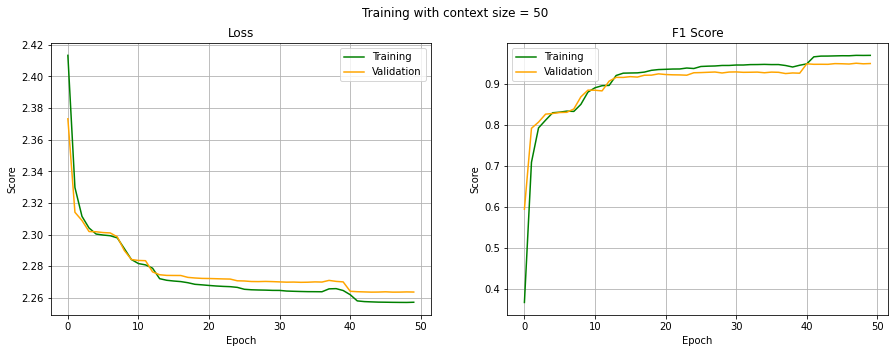

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9684, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9457, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9684, device='cuda:0'),
 tensor(0.9482, device='cuda:0'),
 tensor(0.9457, device='cuda:0'))

## Heatmap

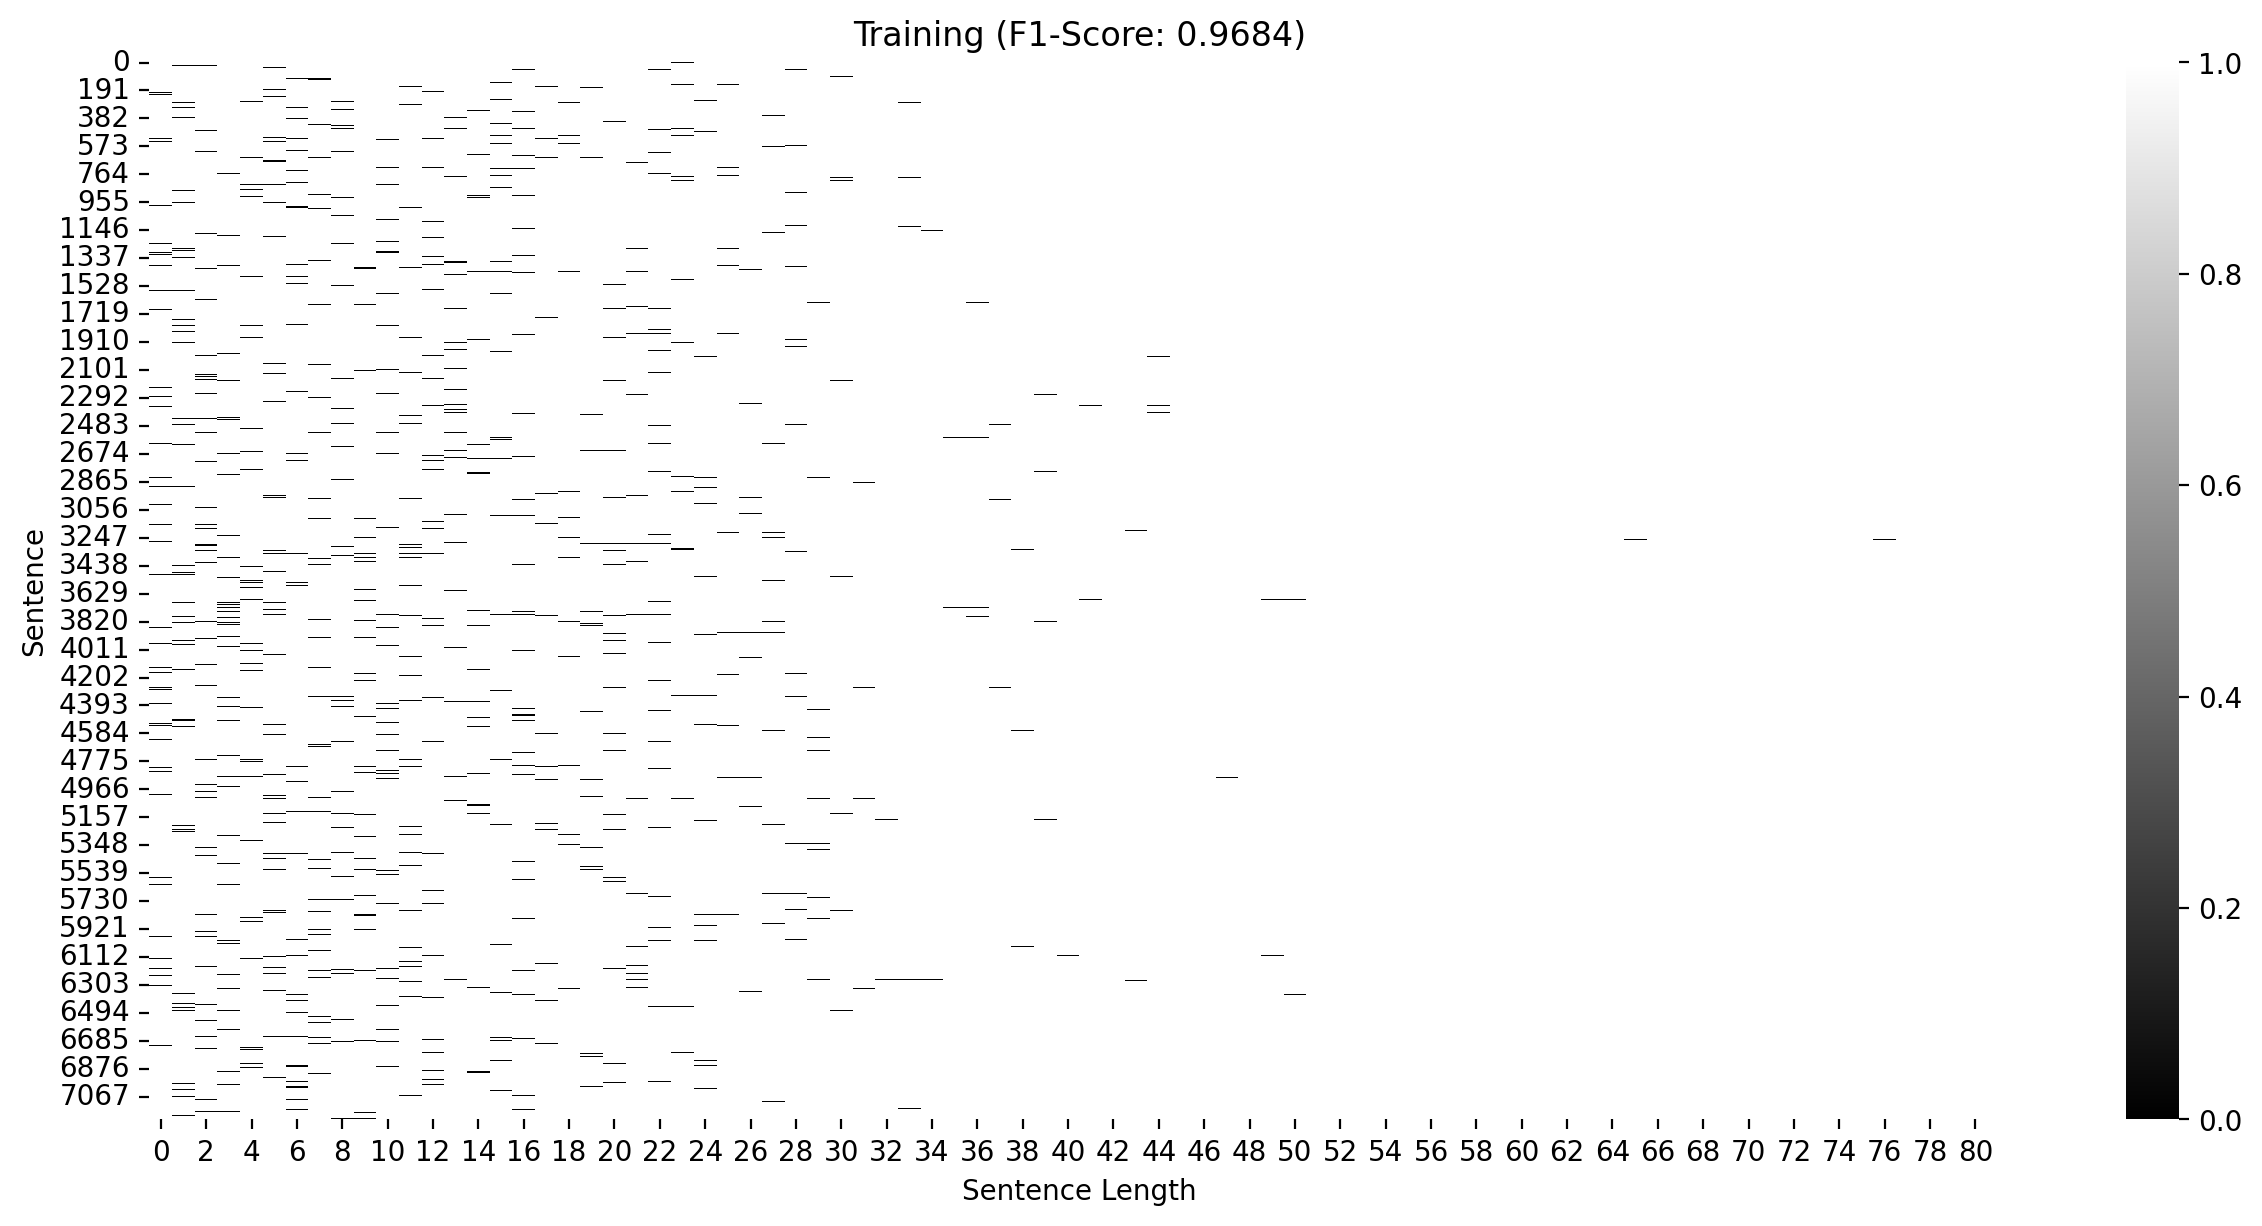

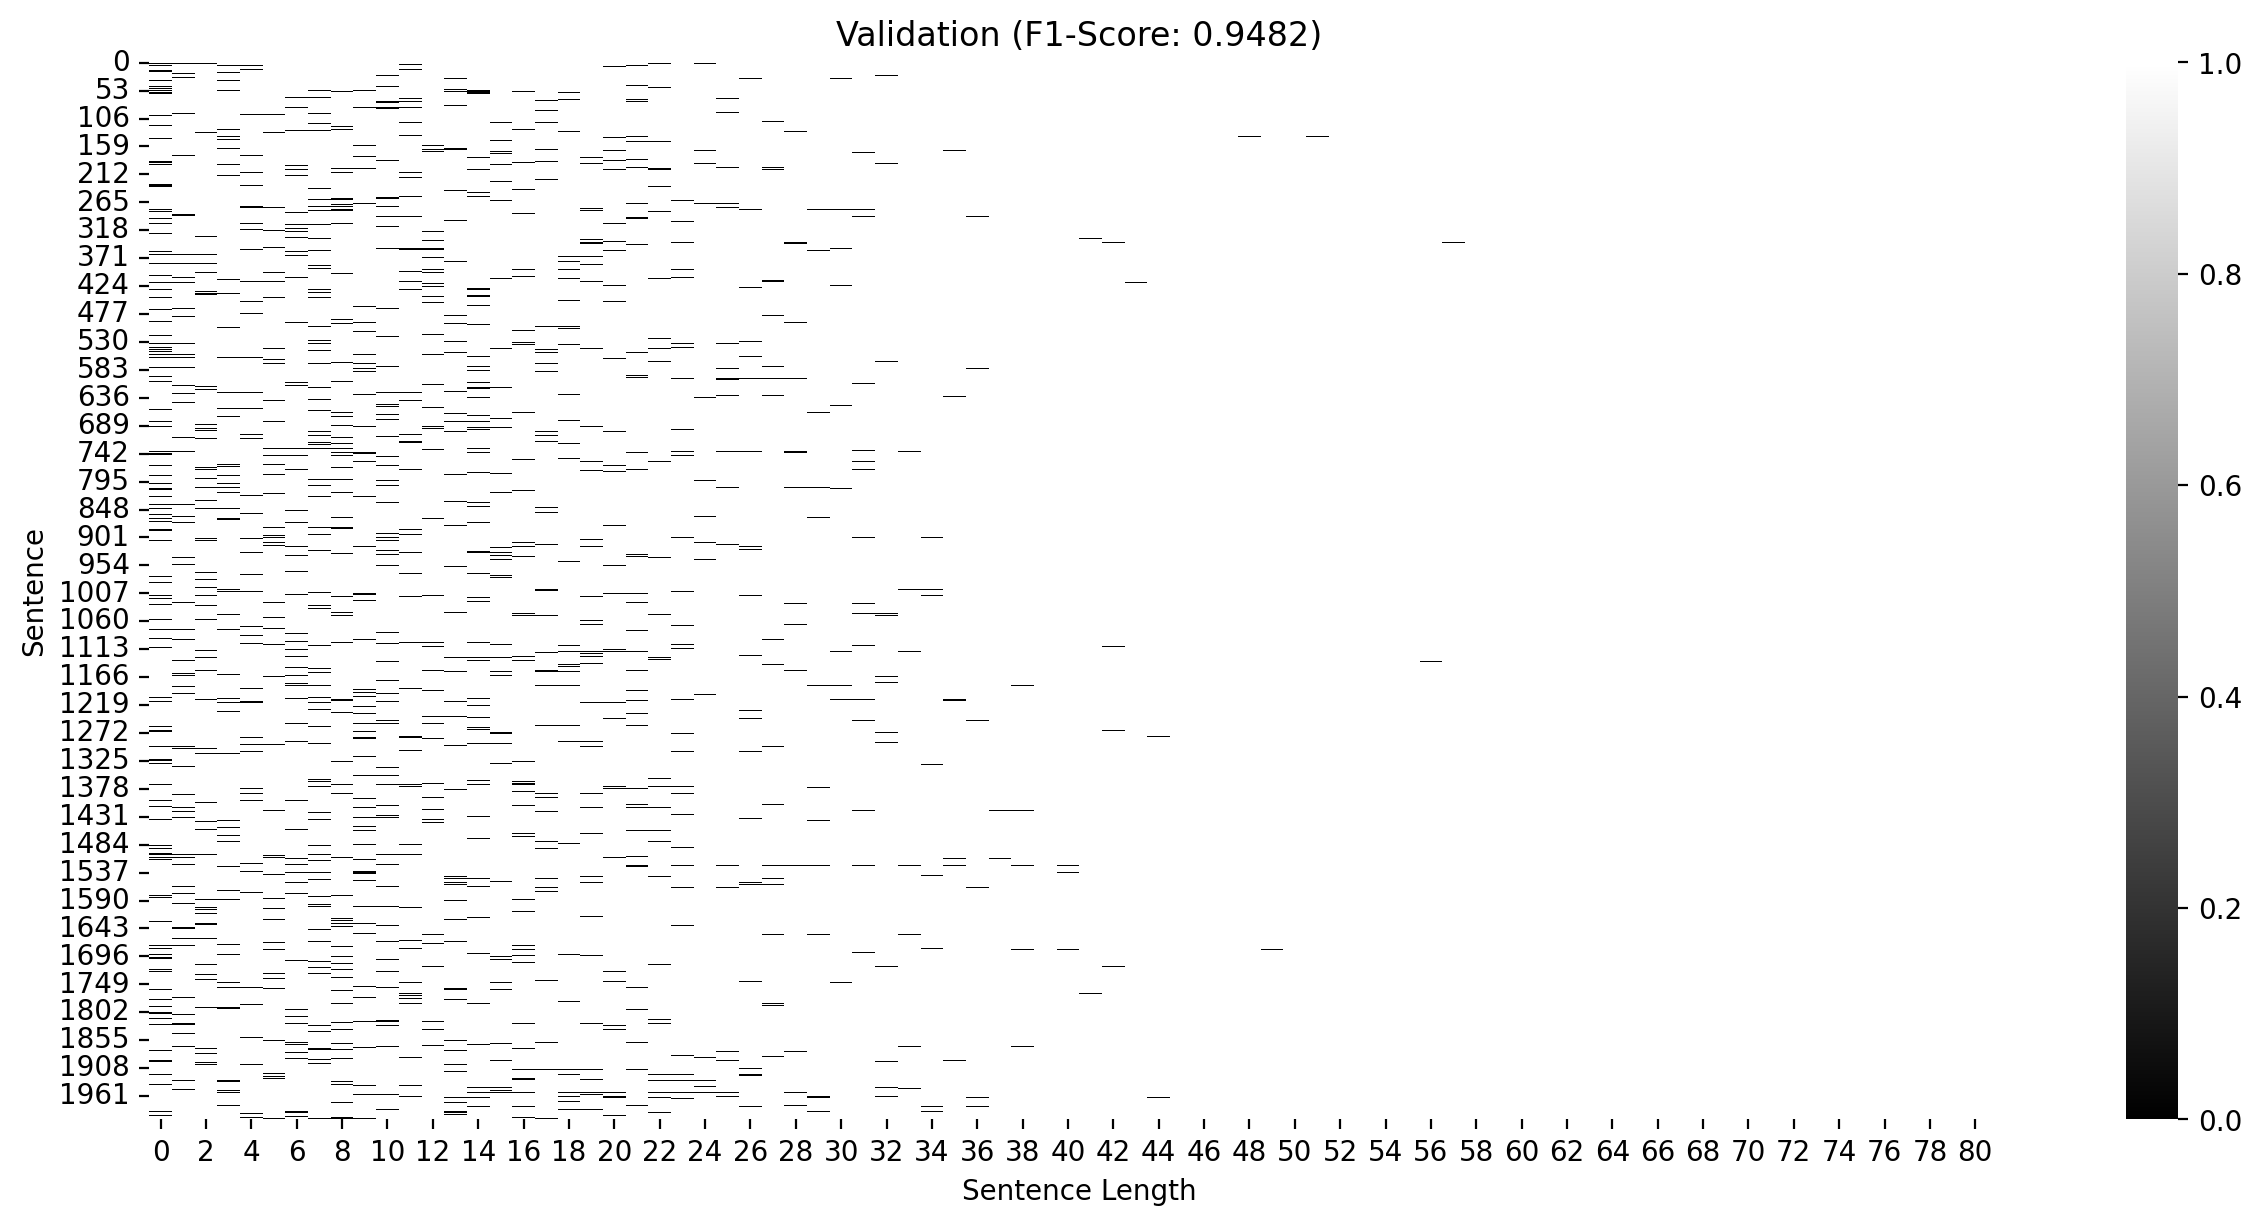

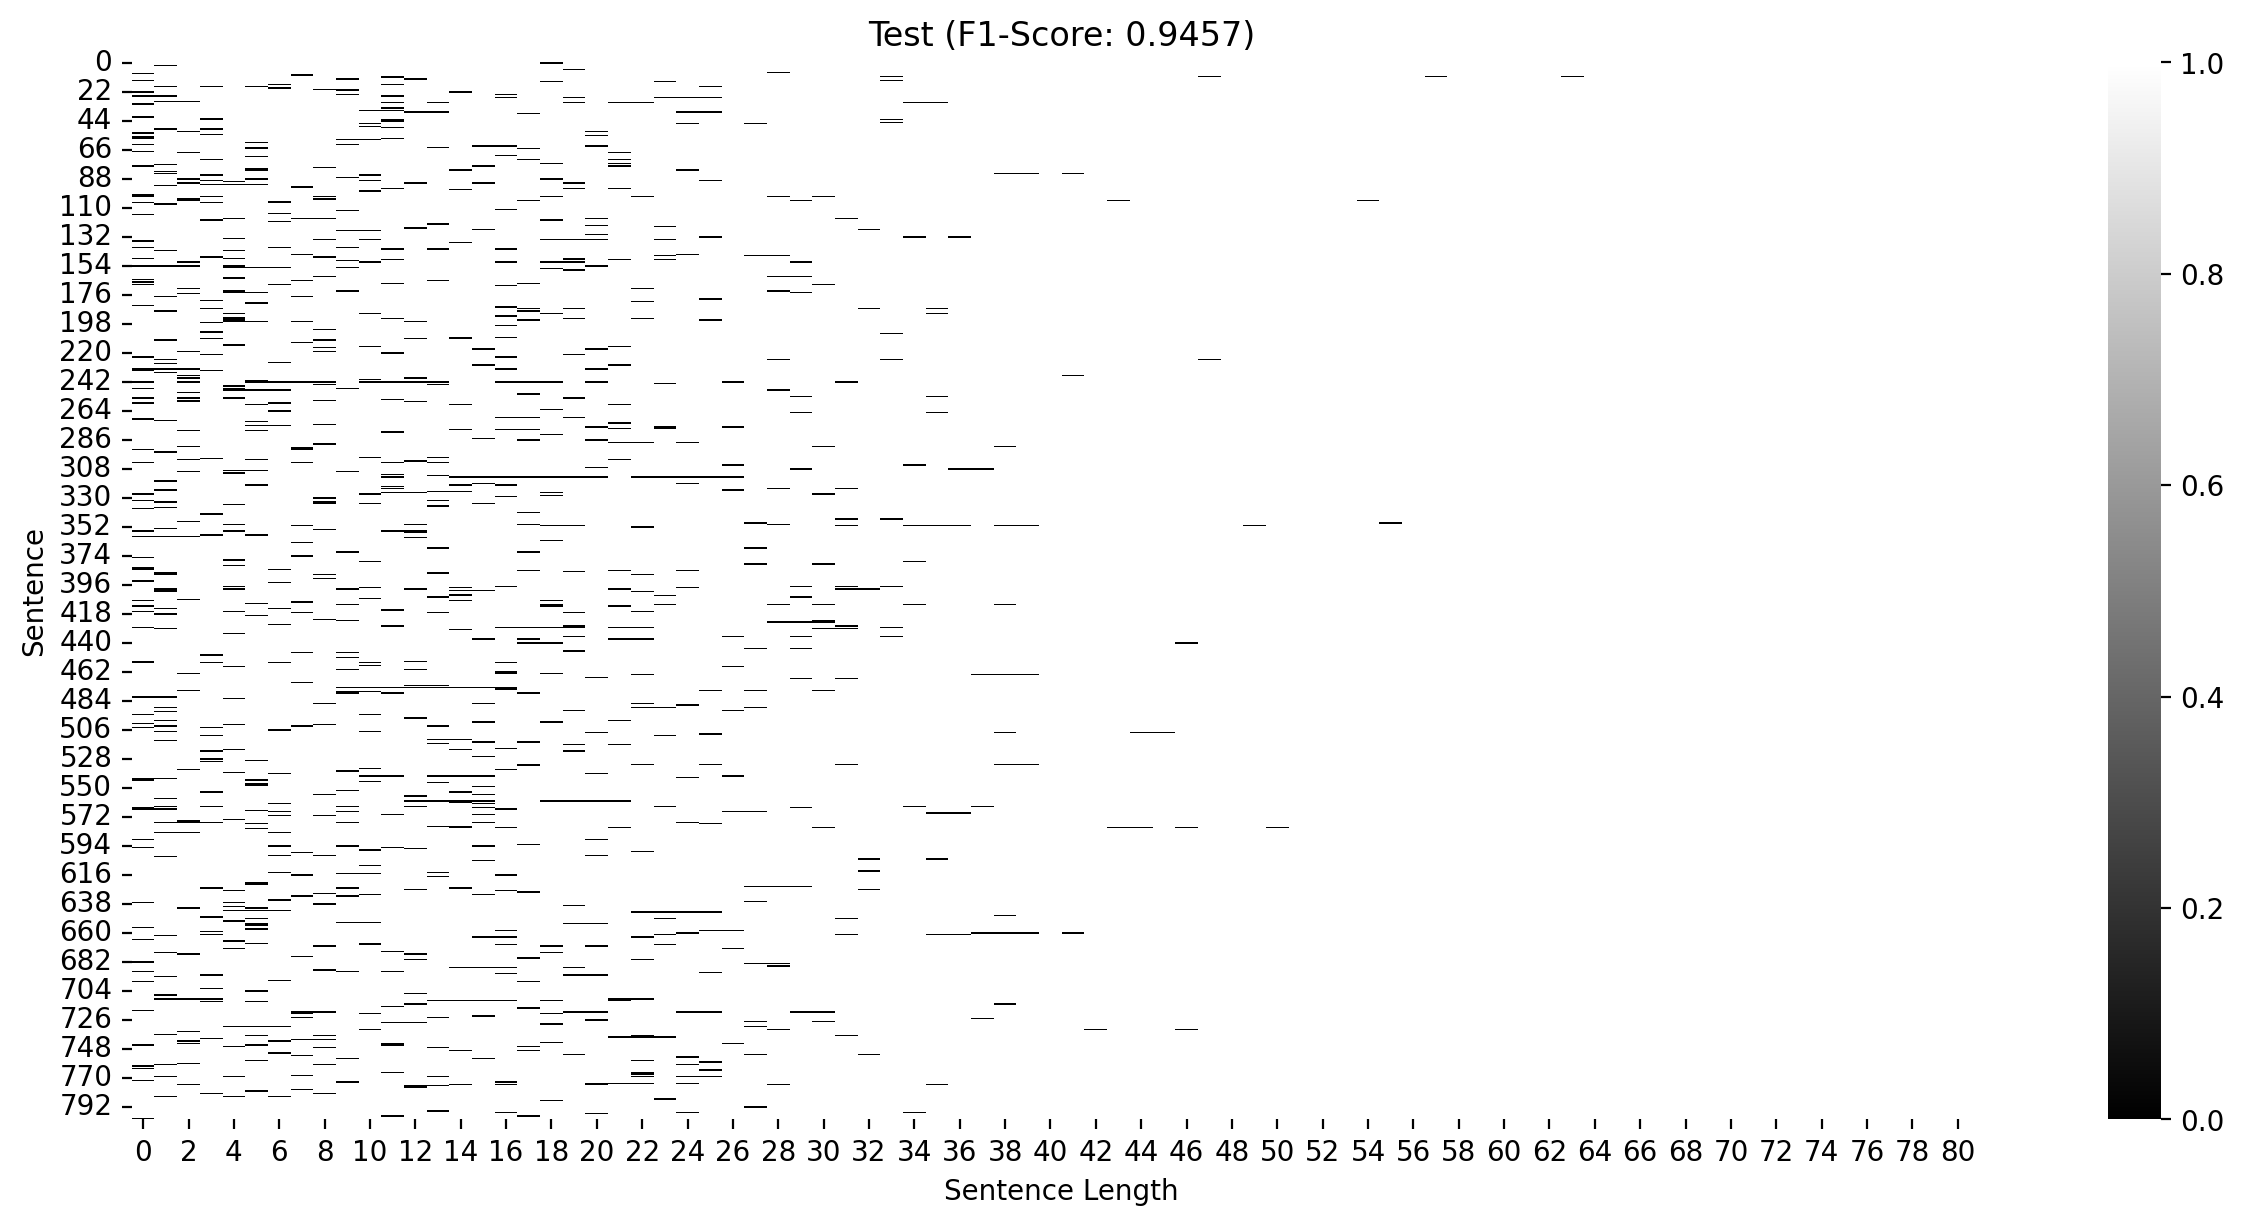

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 168 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


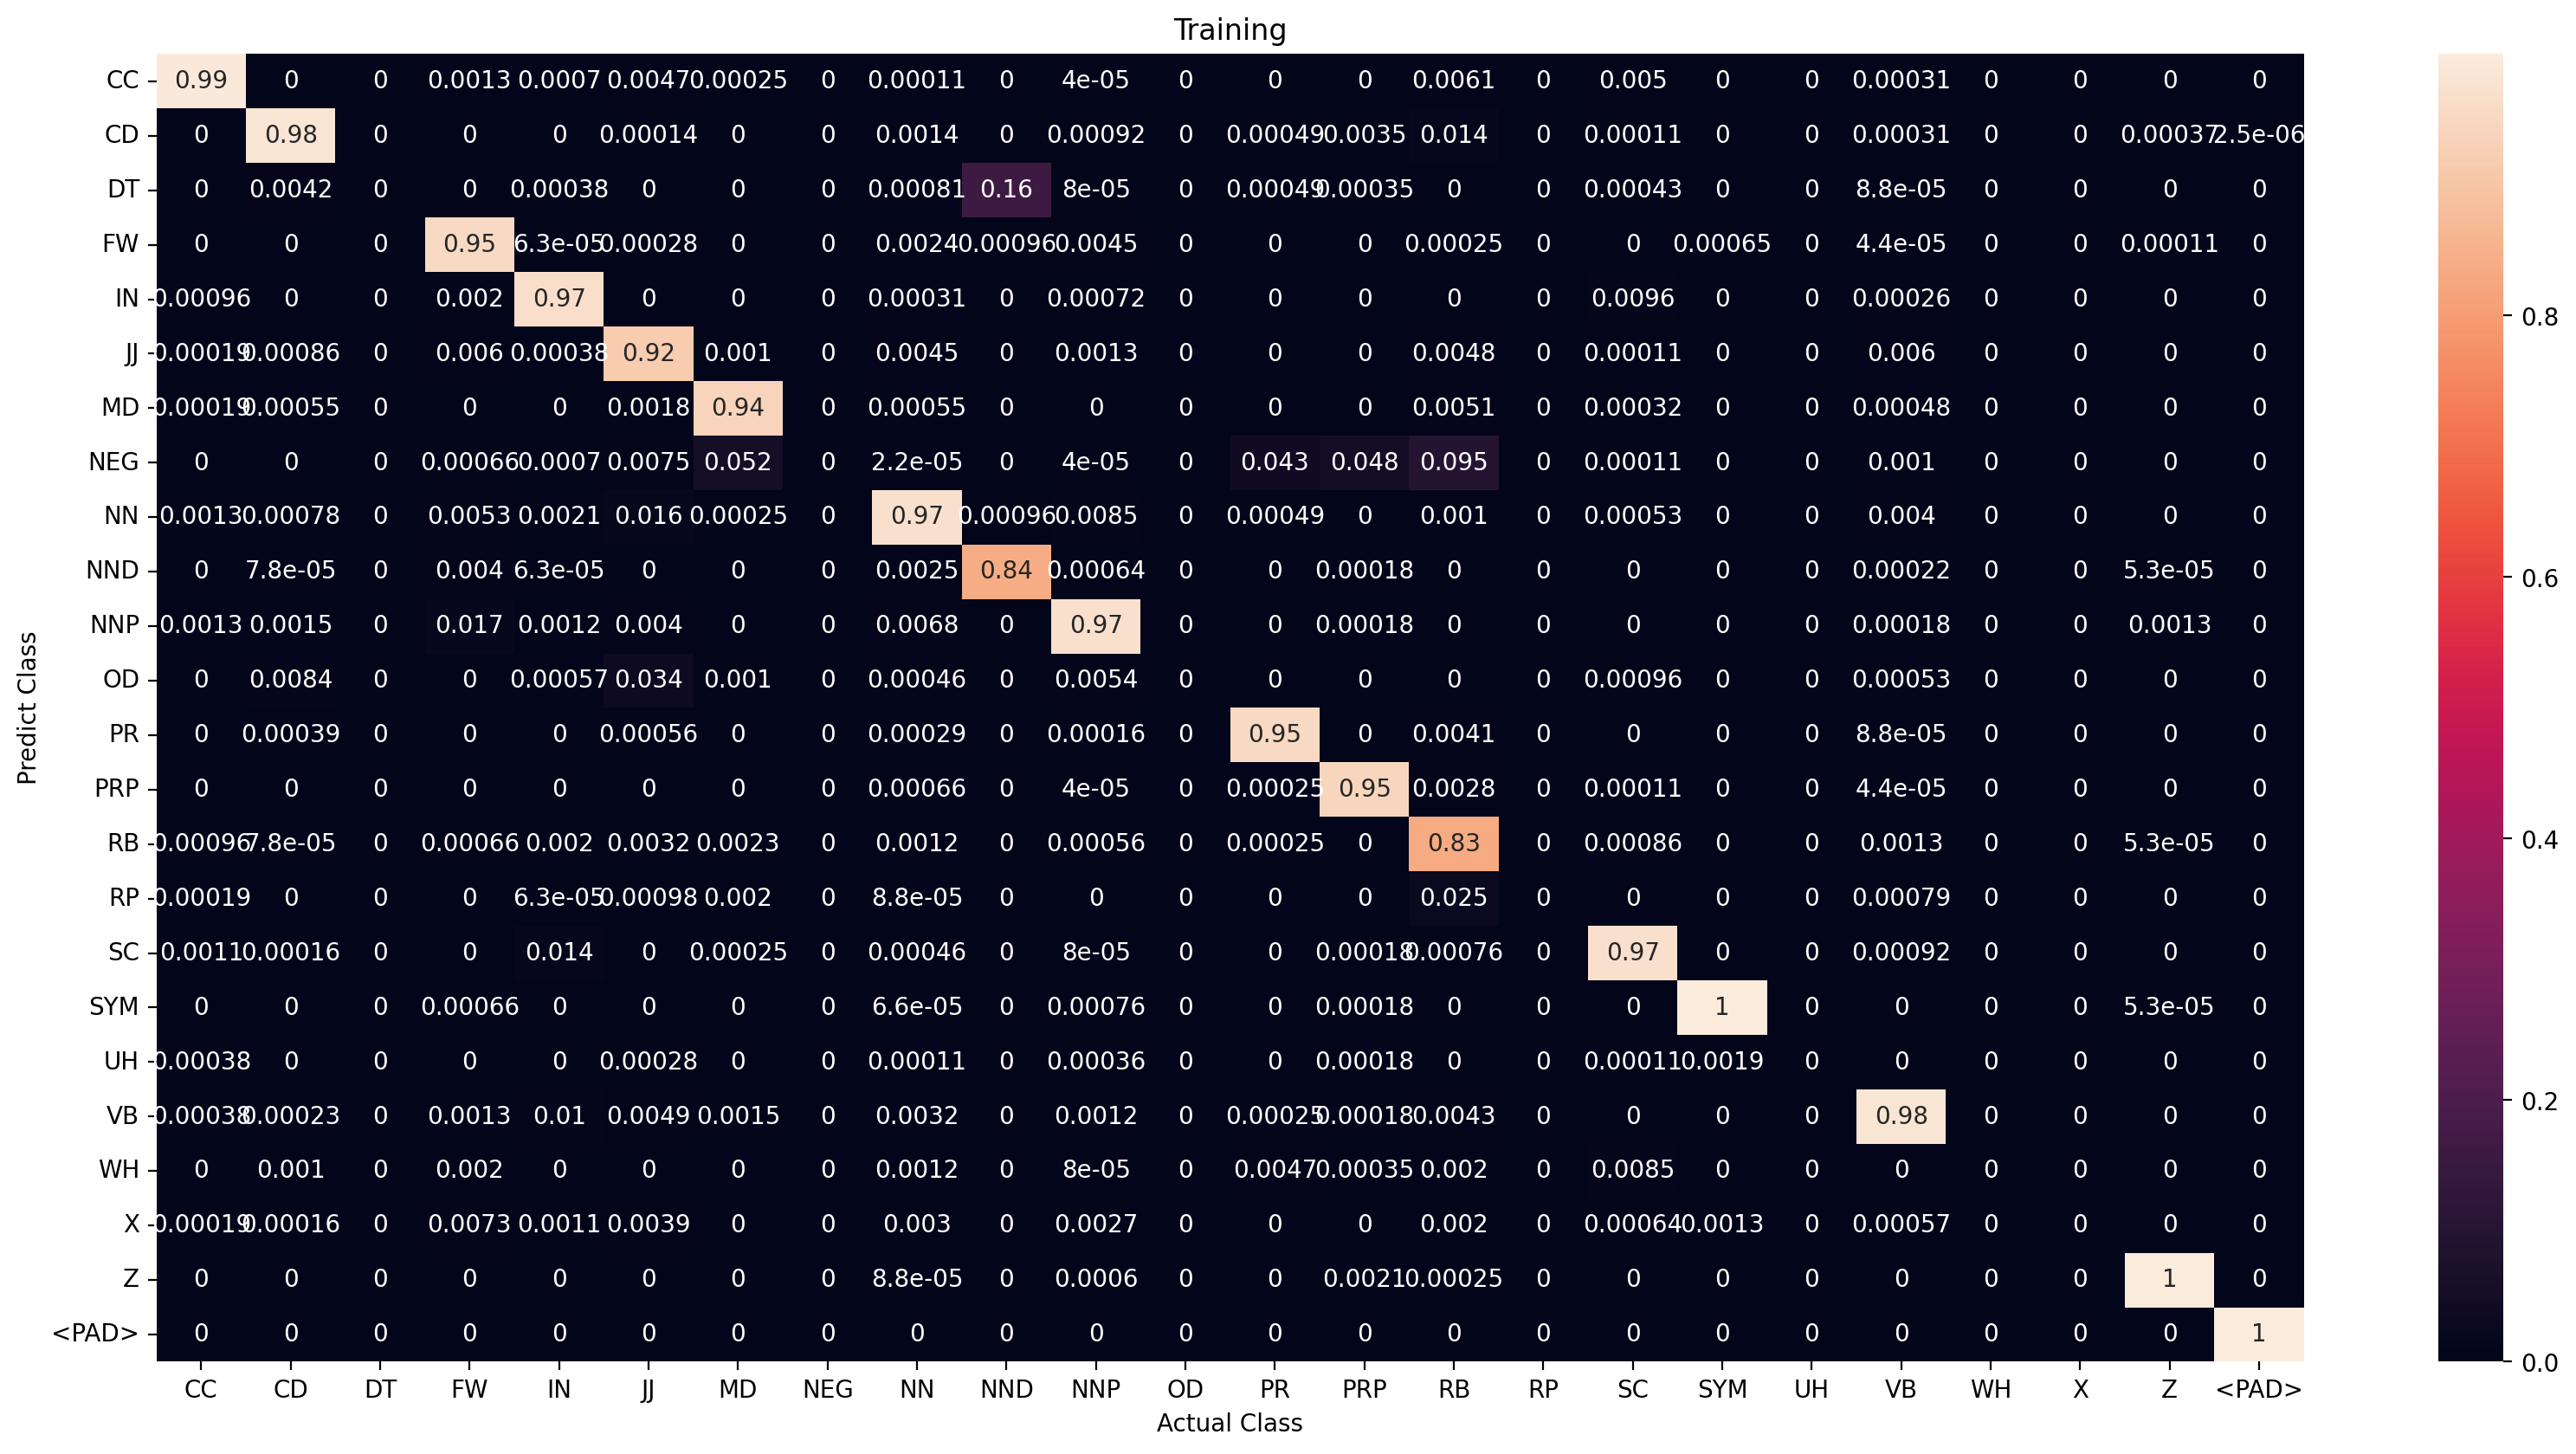

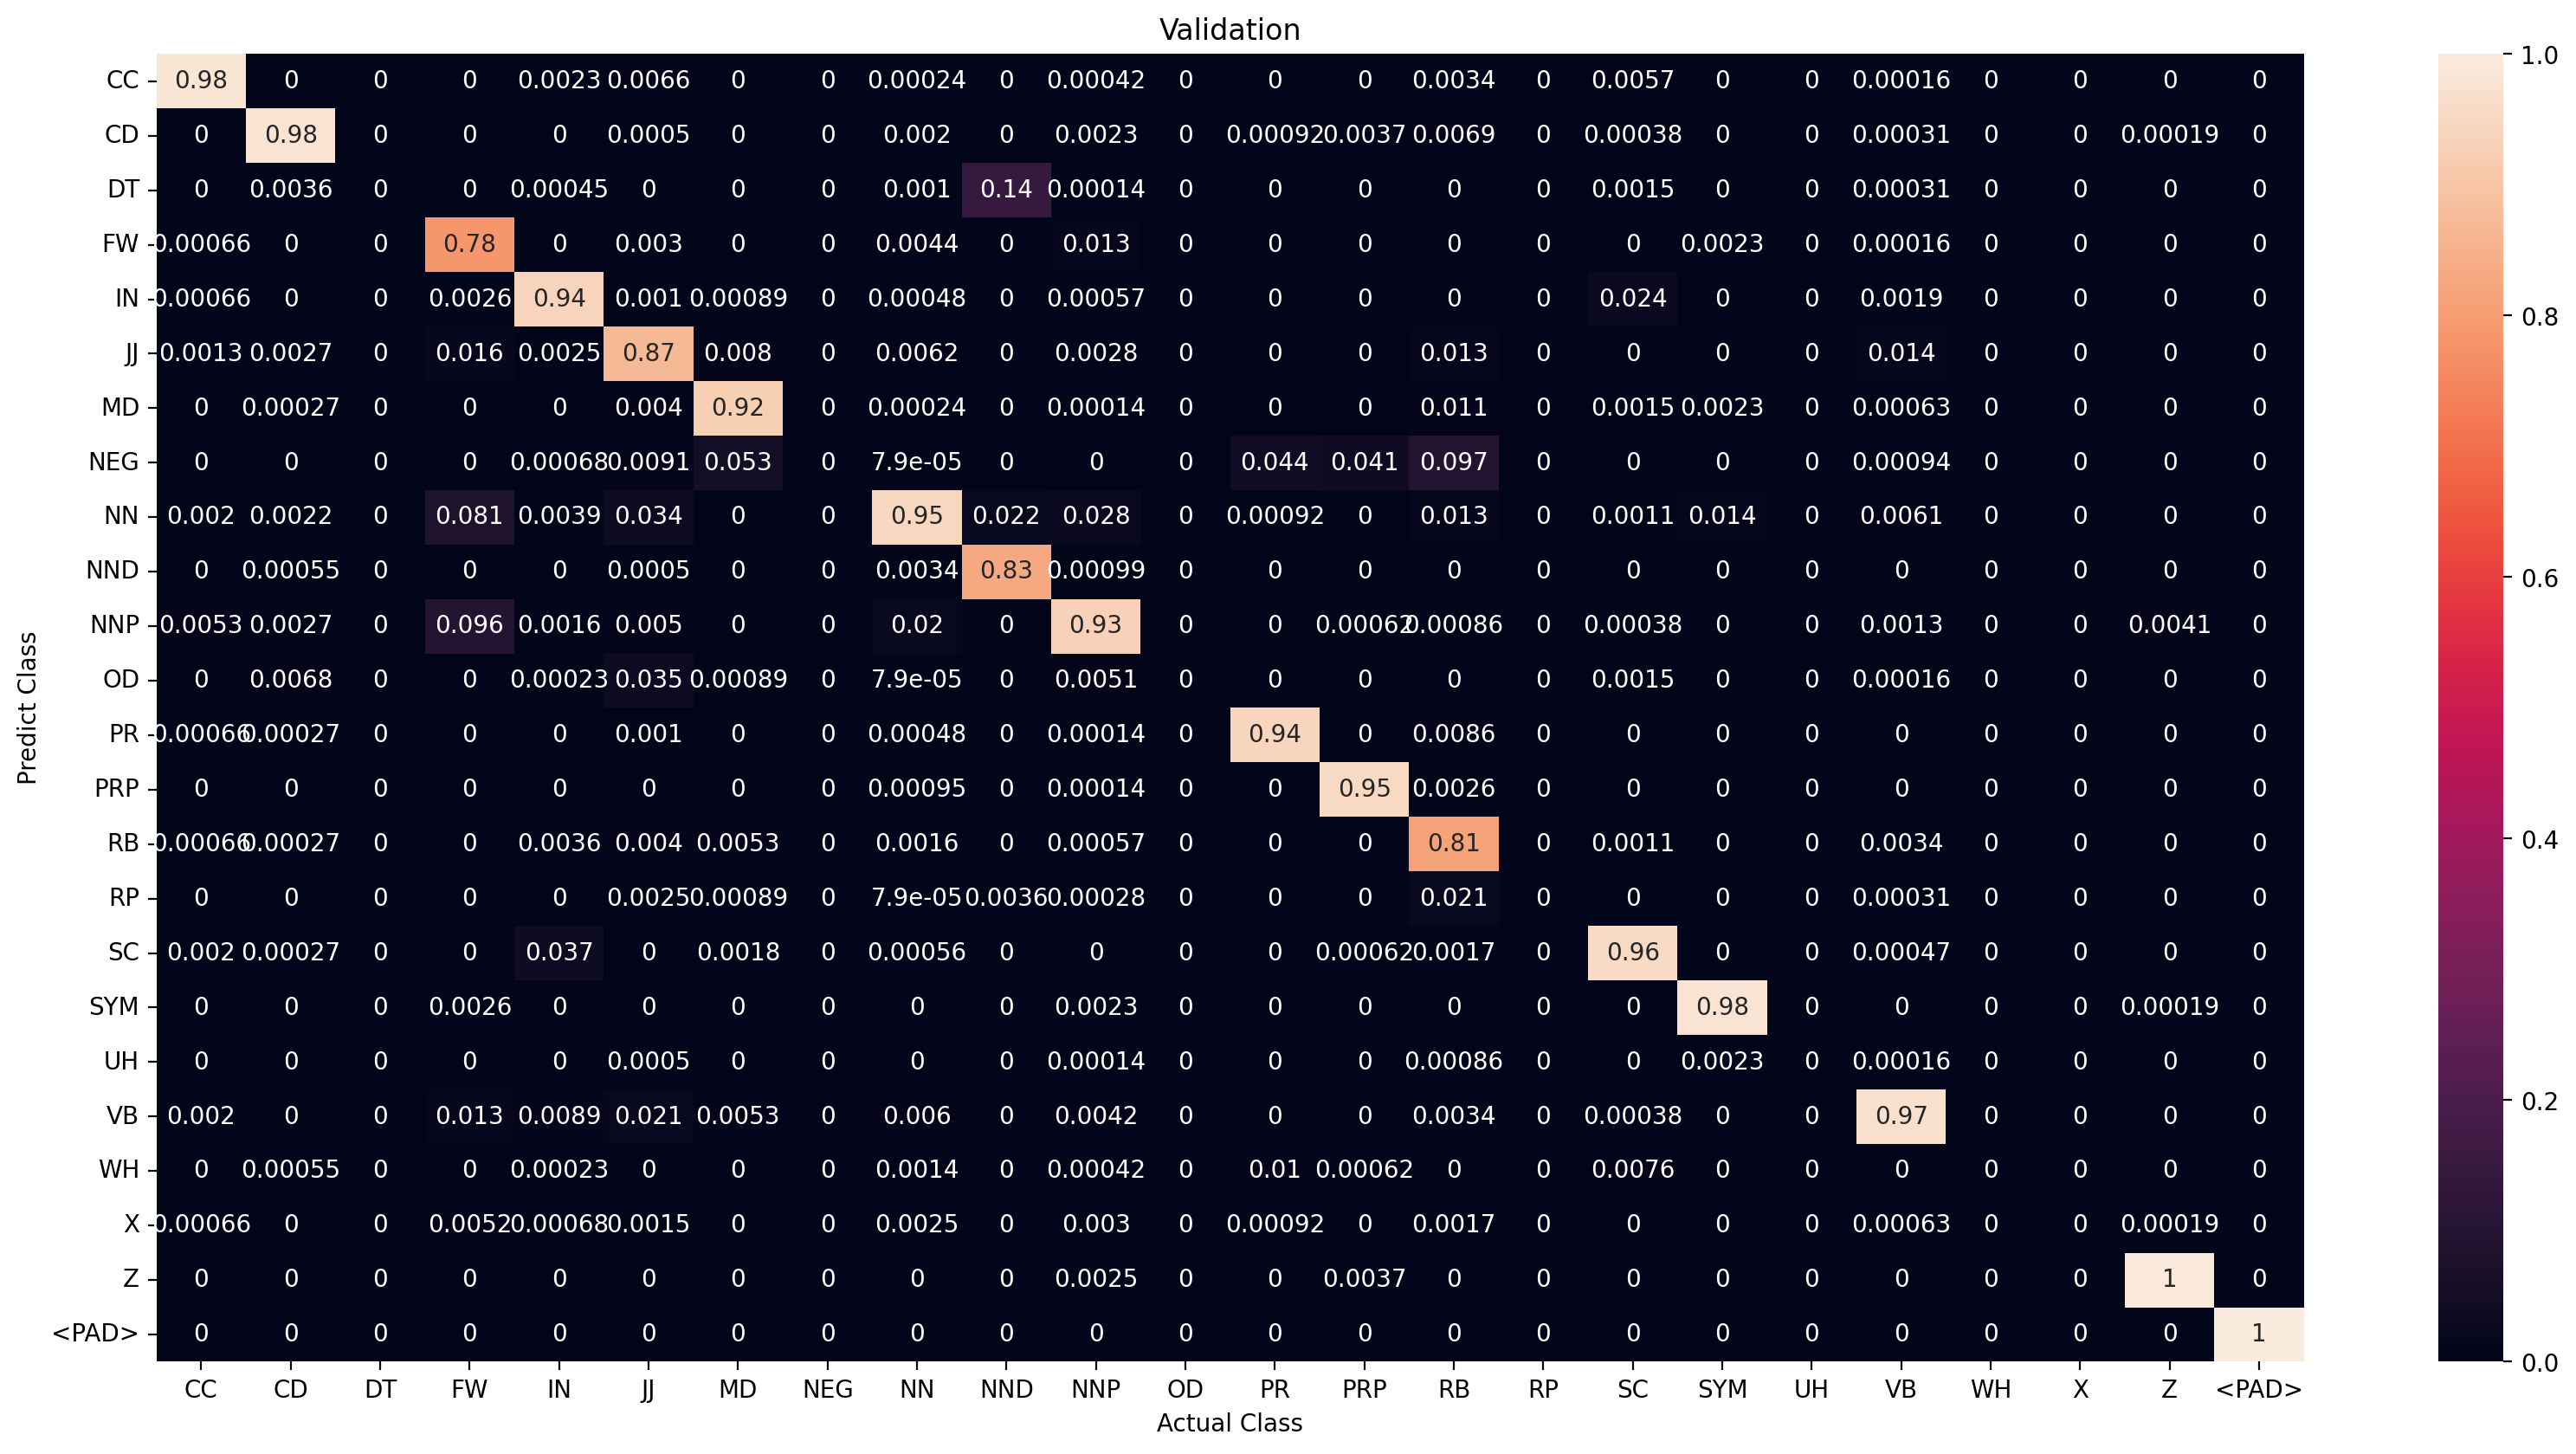

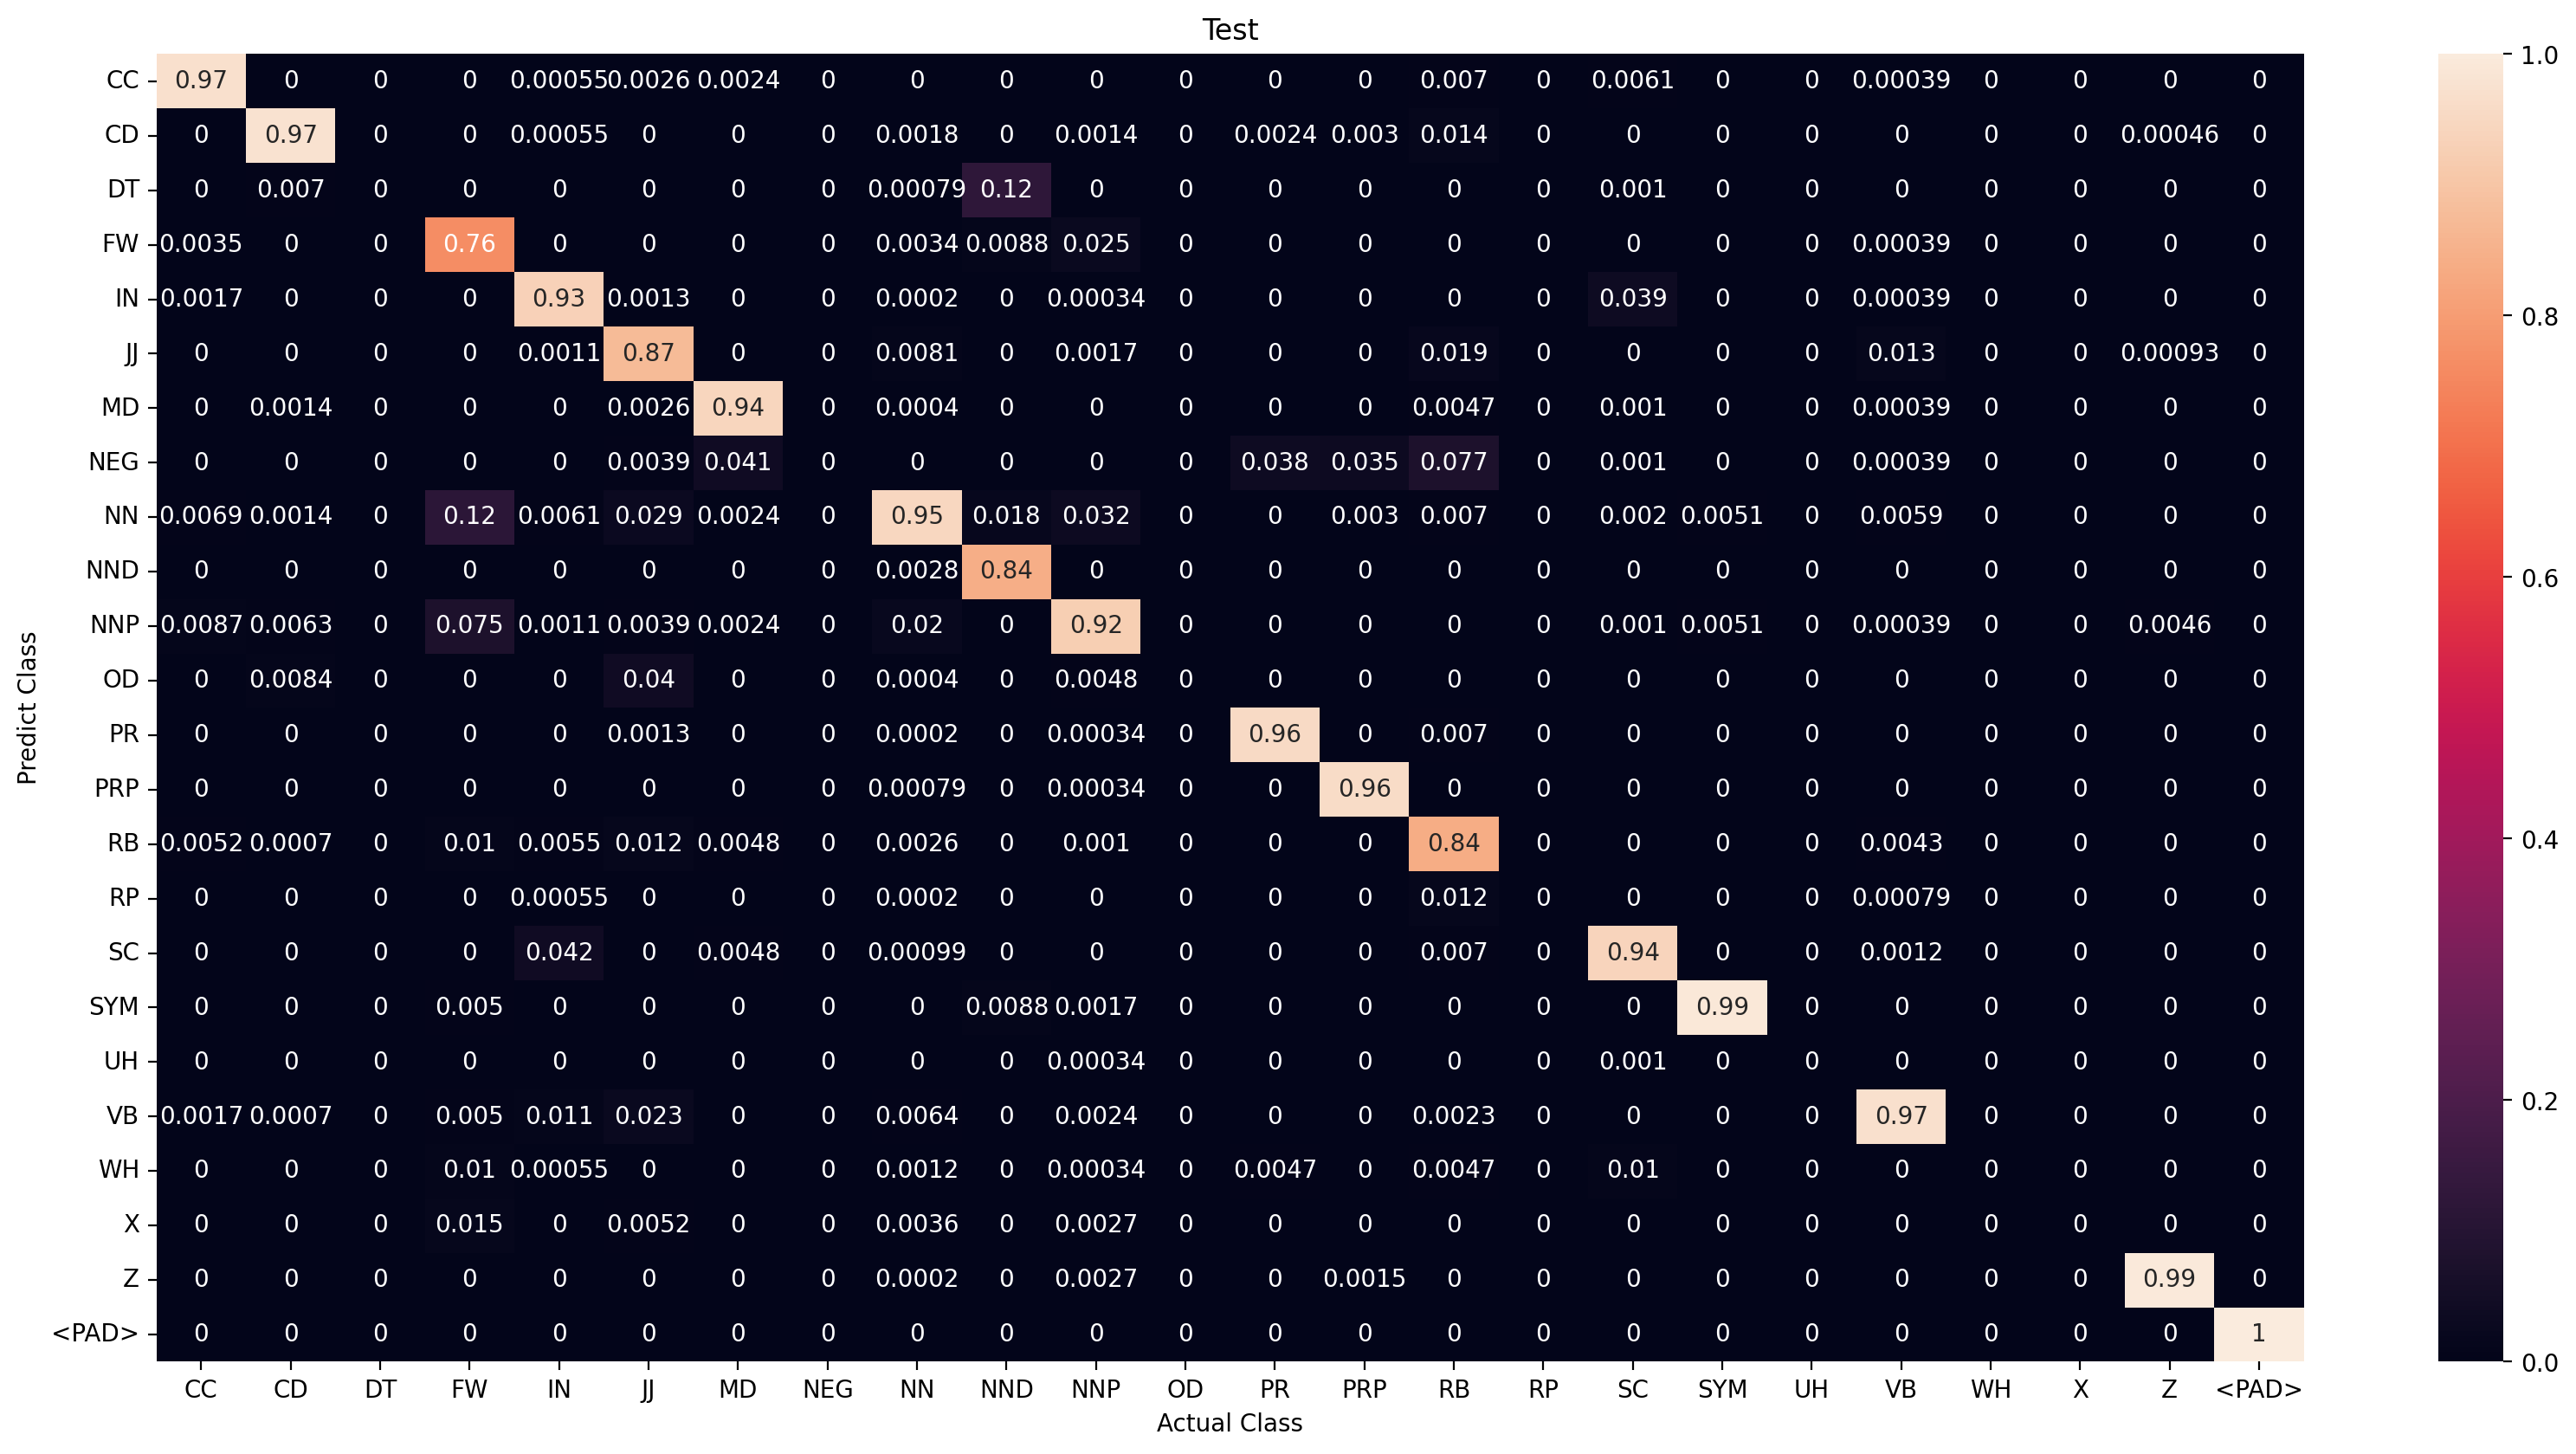

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5322   | CC    : 5190       | CC    : 132      |
| CD    : 12758  | CD    : 12578      | CD    : 180      |
| DT    : 277    | DT    : 0          | DT    : 277      |
| FW    : 1666   | FW    : 1434       | FW    : 232      |
| IN    : 15371  | IN    : 15235      | IN    : 136      |
| JJ    : 6997   | JJ    : 6575       | JJ    : 422      |
| MD    : 3774   | MD    : 3694       | MD    : 80       |
| NEG   : 1113   | NEG   : 0          | NEG   : 1113     |
| NN    : 44672  | NN    : 44178      | NN    : 494      |
| NND   : 1021   | NND   : 874        | NND   : 147      |
| NNP   : 24845  | NNP   : 24407      | NNP   : 438      |
| OD    : 541    | OD    : 0          | OD    : 541      |
| PR    : 3896   | PR    : 3852       | PR    : 44       |
| PRP   : 5408   | PRP   : 5363       | PRP   : 45       |
| RB    : 3463   | RB    : 3284       | RB    : 179      |
| RP    : 137    | RP    : 0          | RP    : 137     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308].detach().cpu() == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11821
Correct prediction          : 11017
Wrong prediction            : 804
Percentage correct oov pred : 93.19854496235513

Validation
Number OOV token            : 3350
Correct prediction          : 2960
Wrong prediction            : 390
Percentage correct oov pred : 88.35820895522389

Test
Number OOV token            : 1391
Correct prediction          : 1235
Wrong prediction            : 156
Percentage correct oov pred : 88.78504672897196



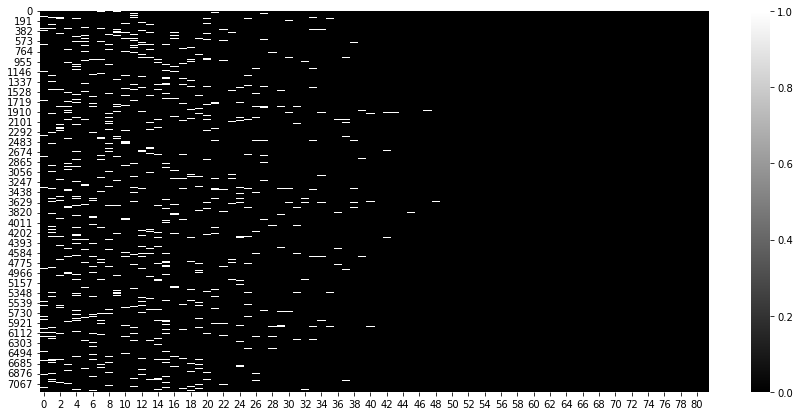

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

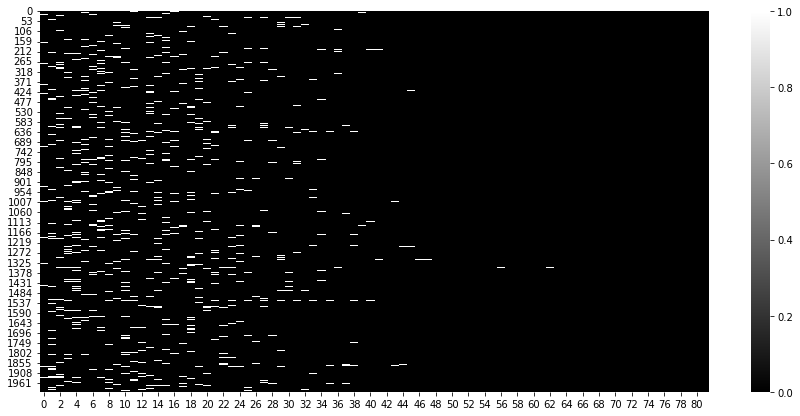

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

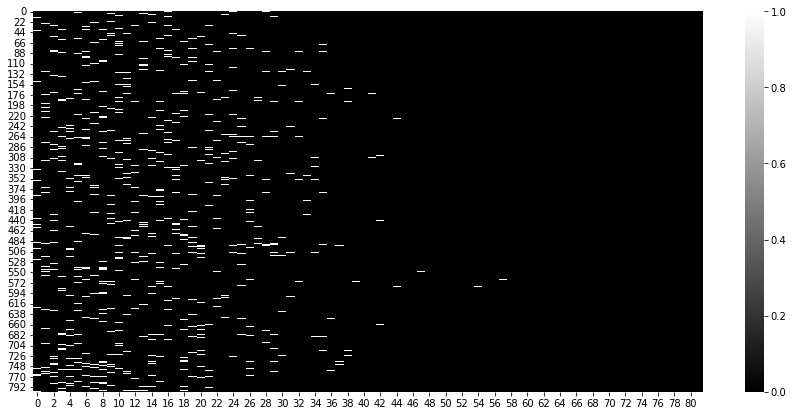

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);